## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('data/Assessment 2 - MMM Weekly.csv')
except FileNotFoundError:
    print("Make sure your data file is in the 'data' folder and named correctly.")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   week              104 non-null    object 
 1   facebook_spend    104 non-null    float64
 2   google_spend      104 non-null    float64
 3   tiktok_spend      104 non-null    float64
 4   instagram_spend   104 non-null    float64
 5   snapchat_spend    104 non-null    float64
 6   social_followers  104 non-null    int64  
 7   average_price     104 non-null    float64
 8   promotions        104 non-null    int64  
 9   emails_send       104 non-null    int64  
 10  sms_send          104 non-null    int64  
 11  revenue           104 non-null    float64
dtypes: float64(7), int64(4), object(1)
memory usage: 9.9+ KB
None


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


## Data Cleaning & Time Series Setup

In [2]:
# Convert the 'week' column to a proper datetime format
df['week'] = pd.to_datetime(df['week'])

# Set the 'week' column as the index of the dataframe
df = df.set_index('week')
df = df.sort_index()

print("\nData correctly indexed by date:")
print(df.head())


Data correctly indexed by date:
            facebook_spend  google_spend  tiktok_spend  instagram_spend  \
week                                                                      
2023-09-17         6030.80       3130.14       2993.22          1841.08   
2023-09-24         5241.44       2704.00          0.00             0.00   
2023-10-01         5893.00          0.00          0.00             0.00   
2023-10-08         7167.16          0.00          0.00             0.00   
2023-10-15         5360.29          0.00          0.00          3237.15   

            snapchat_spend  social_followers  average_price  promotions  \
week                                                                      
2023-09-17         2204.72                 0         101.95           0   
2023-09-24            0.00                 0         103.86           0   
2023-10-01            0.00                 0         100.38           0   
2023-10-08            0.00                 0         103.14       

## Exploratory Data Analysis (EDA)

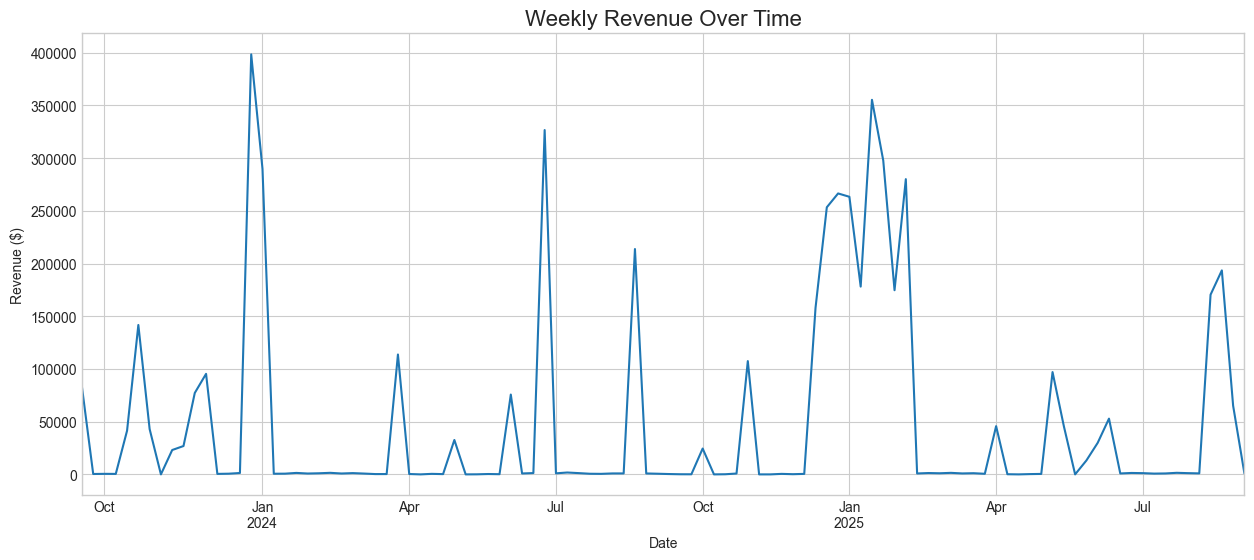

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 6))
df['revenue'].plot(ax=ax)
ax.set_title('Weekly Revenue Over Time', fontsize=16)
ax.set_ylabel('Revenue ($)')
ax.set_xlabel('Date')
plt.show()

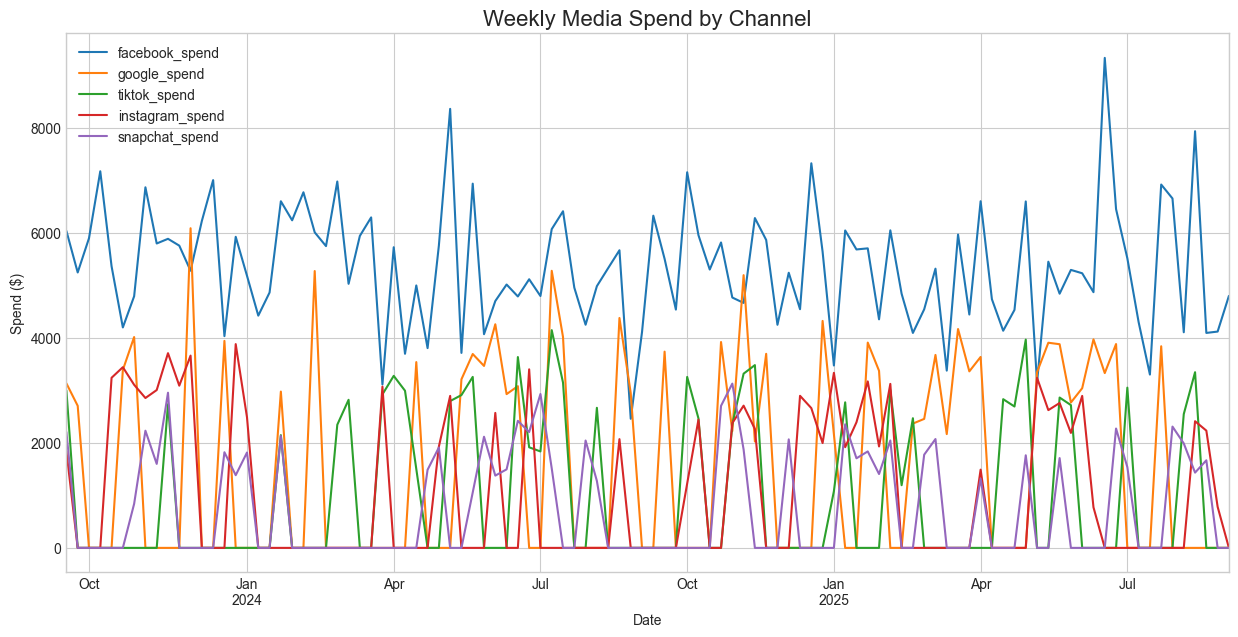

In [4]:
media_spend_cols = [col for col in df.columns if 'spend' in col]
fig, ax = plt.subplots(figsize=(15, 7))
df[media_spend_cols].plot(ax=ax)
ax.set_title('Weekly Media Spend by Channel', fontsize=16)
ax.set_ylabel('Spend ($)')
ax.set_xlabel('Date')
plt.show()

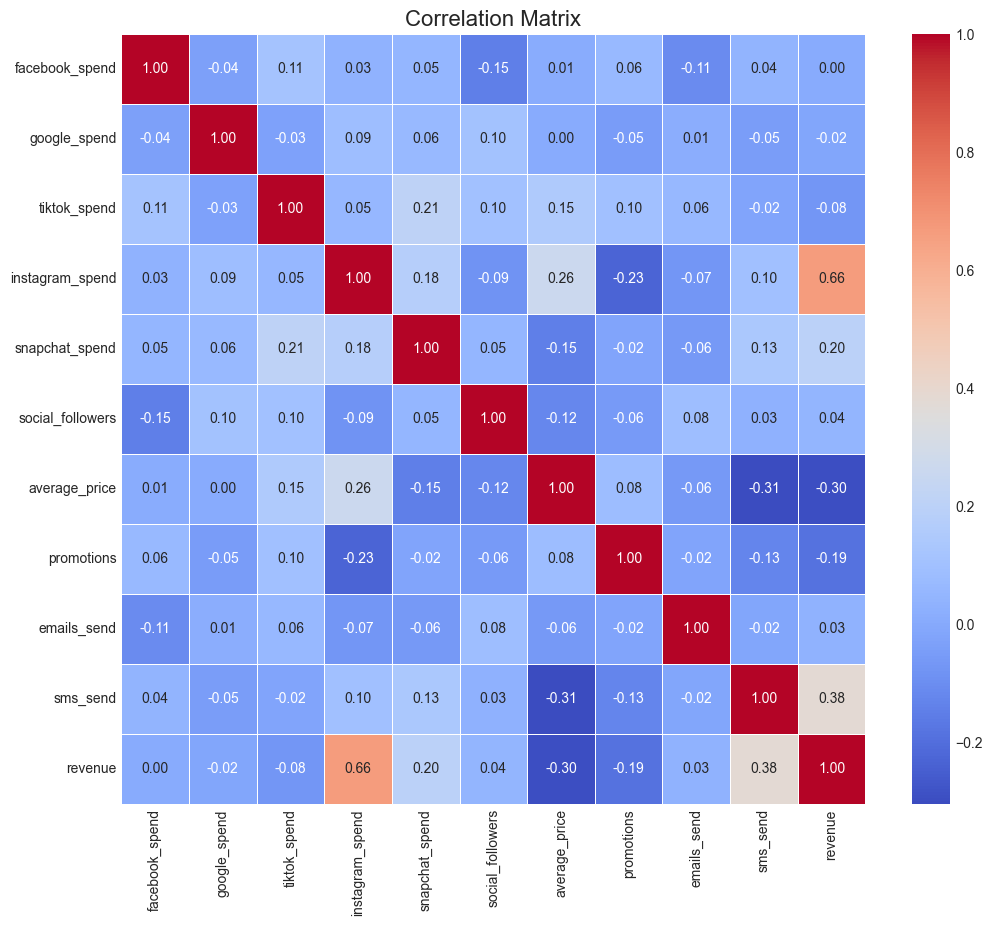

In [5]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## Baseline Model Preparation

In [6]:
# Create a copy of the dataframe for modeling to keep the original clean
df_model = df.copy()

# 1. Simple Feature Engineering for the Baseline
df_model['time_index'] = np.arange(len(df_model)) # For capturing trend
df_model['week_of_year'] = df_model.index.isocalendar().week # For capturing seasonality

# One-hot encode the week_of_year to avoid treating it as a continuous number
df_model = pd.get_dummies(df_model, columns=['week_of_year'], drop_first=True)

# 2. Correct Time-Based Train-Test Split
# We train on the past and test on the most recent future.
split_point = int(len(df_model) * 0.8)
train = df_model.iloc[:split_point]
test = df_model.iloc[split_point:]

# Define features (X) and target (y)
features = [col for col in df_model.columns if col != 'revenue']
X_train, y_train = train[features], train['revenue']
X_test, y_test = test[features], test['revenue']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (83, 62)
Testing data shape: (21, 62)


## Baseline Model Training & Evaluation

--- Baseline Model Performance ---
Mean Absolute Error (MAE): $58,417.56
R-squared (R²): -0.695


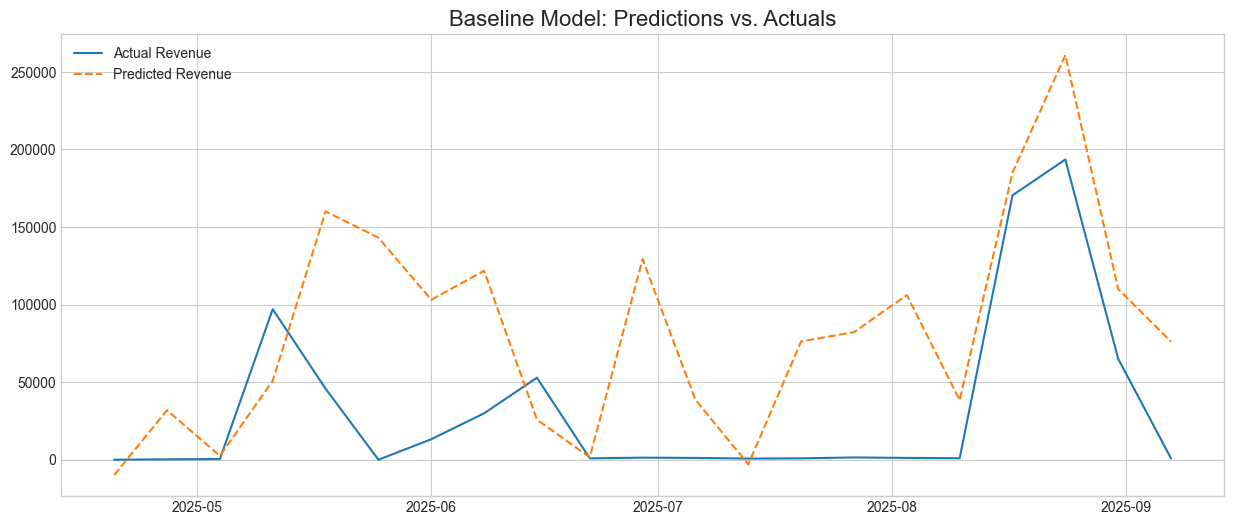

In [7]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# It's best practice to scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Ridge model
# The 'alpha' parameter controls regularization strength. 1.0 is a good default.
baseline_model = Ridge(alpha=1.0)
baseline_model.fit(X_train_scaled, y_train)

# Make predictions on the unseen test data
predictions = baseline_model.predict(X_test_scaled)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("--- Baseline Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae:,.2f}")
print(f"R-squared (R²): {r2:.3f}")

# Plotting predictions vs actuals can be very insightful
plt.figure(figsize=(15, 6))
plt.plot(test.index, y_test, label='Actual Revenue')
plt.plot(test.index, predictions, label='Predicted Revenue', linestyle='--')
plt.title('Baseline Model: Predictions vs. Actuals', fontsize=16)
plt.legend()
plt.show()

## Feature Engineering

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_absolute_error

# ------------------------------
# Adstock Transformation
# geometric decay function for adstock.
def geometric_adstock(spend, decay_rate):
    adstocked_spend = np.zeros_like(spend, dtype=float)
    adstocked_spend[0] = spend[0]
    for i in range(1, len(spend)):
        adstocked_spend[i] = spend[i] + decay_rate * adstocked_spend[i-1]
    return adstocked_spend

# We need to choose a decay rate for each channel. This is a hyperparameter
decay_rates = {
    'facebook_spend': 0.5,
    'google_spend': 0.4,
    'tiktok_spend': 0.3,
    'instagram_spend': 0.5,
    'snapchat_spend': 0.2
}

# Apply adstock to each spend column
for channel, rate in decay_rates.items():
    df[f'{channel}_adstock'] = geometric_adstock(df[channel], rate)

# ------------------------------
# Saturation Transformation
# ------------------------------
# creates a curve with diminishing returns.
def saturate(spend, exponent=0.75):
    return np.power(spend, exponent)

# Apply saturation to the adstocked spend columns
adstock_cols = [col for col in df.columns if 'adstock' in col]
for col in adstock_cols:
    df[f'{col}_saturated'] = saturate(df[col])

# ------------------------------
# Time-Based Features
# ------------------------------
# These help the model understand the underlying patterns in the data over time.
df['time_index'] = np.arange(len(df)) # To model the trend
df['month'] = df.index.month # To model seasonality

# Create dummy variables for the month
df = pd.get_dummies(df, columns=['month'], drop_first=True)

print("Feature engineering complete. Adstock, saturation, and time features added.")
display(df.head())

Feature engineering complete. Adstock, saturation, and time features added.


C:\Users\Shreya Nithin\AppData\Local\Temp\ipykernel_8700\2848789437.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[0] = spend[0]
C:\Users\Shreya Nithin\AppData\Local\Temp\ipykernel_8700\2848789437.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[i] = spend[i] + decay_rate * adstocked_spend[i-1]
C:\Users\Shreya Nithin\AppData\Local\Temp\ipykernel_8700\2848789437.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
week,,,,,,,,,,,,,,,,,,,,,
2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,...,False,False,False,False,False,False,True,False,False,False
2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,...,False,False,False,False,False,False,True,False,False,False
2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,...,False,False,False,False,False,False,False,True,False,False
2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,...,False,False,False,False,False,False,False,True,False,False
2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,...,False,False,False,False,False,False,False,True,False,False


## Building a Baseline Model

In [9]:
# ------------------------------
# Define Features and Target for Baseline
# ------------------------------
# Using raw spend, not adstocked/saturated spend
baseline_spend_features = [
    'facebook_spend', 'google_spend', 'tiktok_spend',
    'instagram_spend', 'snapchat_spend'
]
control_features = [
    'social_followers', 'average_price', 'promotions',
    'emails_send', 'sms_send', 'time_index'
]
month_features = [col for col in df.columns if 'month_' in col]

X_baseline = df[baseline_spend_features + control_features + month_features]
y = df['revenue']

# ------------------------------
# Time-Series Split
# ------------------------------
# Split the data chronologically to prevent data leakage.
split_point = int(len(df) * 0.8)
X_baseline_train, X_baseline_test = X_baseline.iloc[:split_point], X_baseline.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# ------------------------------
# Train and Evaluate Baseline Model
# ------------------------------
baseline_model = Ridge(alpha=1.0)
baseline_model.fit(X_baseline_train, y_train)
baseline_preds = baseline_model.predict(X_baseline_test)

baseline_r2 = r2_score(y_test, baseline_preds)
baseline_mae = mean_absolute_error(y_test, baseline_preds)

print("--- Baseline Model Performance ---")
print(f"R-squared: {baseline_r2:.3f}")
print(f"Mean Absolute Error (MAE): ${baseline_mae:,.2f}")

--- Baseline Model Performance ---
R-squared: -0.257
Mean Absolute Error (MAE): $52,717.74


## The Two-Stage Causal Model

In [10]:
from sklearn.preprocessing import StandardScaler

# CREATE THE COMBINED SOCIAL SPEND FEATURE

social_spend_cols = ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
df['total_social_spend'] = df[social_spend_cols].sum(axis=1)

# Apply adstock and saturation to this new combined feature
df['total_social_spend_adstock'] = geometric_adstock(df['total_social_spend'], decay_rate=0.5)
df['total_social_spend_adstock_saturated'] = saturate(df['total_social_spend_adstock'], exponent=0.75)
print("Created 'total_social_spend' feature.")
print("-" * 50)


# STAGE 1: MODEL GOOGLE SPEND

# The features for the mediator model  include the single social spend feature
y1 = df['google_spend_adstock_saturated']
X1_features_revised = [
    'total_social_spend_adstock_saturated' 
] + control_features + month_features
X1 = df[X1_features_revised]

X1_train, X1_test, y1_train, y1_test = X1.iloc[:split_point], X1.iloc[split_point:], y1.iloc[:split_point], y1.iloc[split_point:]

scaler_X1 = StandardScaler()
X1_train_scaled = scaler_X1.fit_transform(X1_train)

model_stage1 = Ridge(alpha=50.0)
model_stage1.fit(X1_train_scaled, y1_train)

X1_scaled = scaler_X1.transform(X1)
df['predicted_google_spend'] = model_stage1.predict(X1_scaled)
df['residual_google_spend'] = df['google_spend_adstock_saturated'] - df['predicted_google_spend']
print("Stage 1 (Mediator Model) is complete.")
print("-" * 50)


# STAGE 2: MODEL REVENUE  

y2 = df['revenue']
final_features_revised = [
    'total_social_spend_adstock_saturated' 
] + [
    'predicted_google_spend', 'residual_google_spend'
] + control_features + month_features
X2 = df[final_features_revised]

X2_train, X2_test, y2_train, y2_test = X2.iloc[:split_point], X2.iloc[split_point:], y.iloc[:split_point], y.iloc[split_point:]

scaler_X2 = StandardScaler()
X2_train_scaled = scaler_X2.fit_transform(X2_train)
X2_test_scaled = scaler_X2.transform(X2_test)

final_model = Ridge(alpha=50.0)
final_model.fit(X2_train_scaled, y2_train)
print("Stage 2 (Final Revenue Model) is complete.")
print("-" * 50)

Created 'total_social_spend' feature.
--------------------------------------------------
Stage 1 (Mediator Model) is complete.
--------------------------------------------------
Stage 2 (Final Revenue Model) is complete.
--------------------------------------------------


C:\Users\Shreya Nithin\AppData\Local\Temp\ipykernel_8700\2848789437.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[0] = spend[0]
C:\Users\Shreya Nithin\AppData\Local\Temp\ipykernel_8700\2848789437.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adstocked_spend[i] = spend[i] + decay_rate * adstocked_spend[i-1]


## Model Evaluation and Interpretation

--- Final Model Performance (After Combining Features) ---
R-squared: -0.285
Mean Absolute Error (MAE): $51,042.62


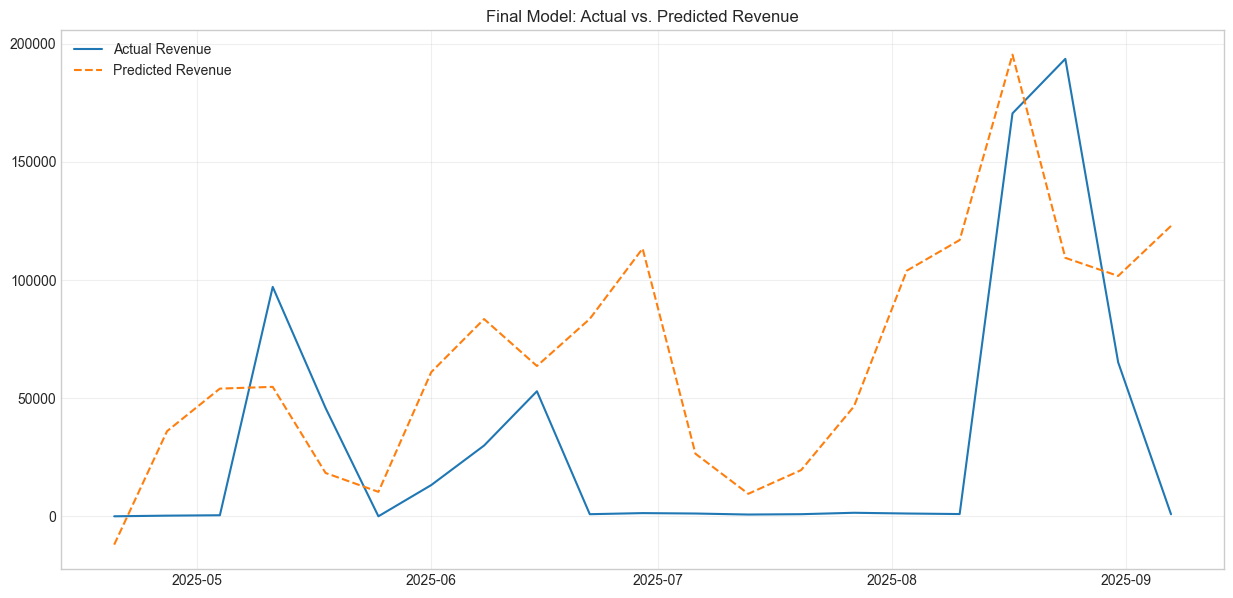


--- Final Model Coefficients ---


,Feature,Coefficient
0,total_social_spend_adstock_saturated,23984.882546
7,sms_send,19121.960224
19,month_12,9750.463763
3,social_followers,6153.841428
8,time_index,6093.096335
16,month_9,-945.747139
13,month_6,-1408.661791
17,month_10,-1431.197269
2,residual_google_spend,-1980.575486
1,predicted_google_spend,-2088.737511


In [11]:
final_preds = final_model.predict(X2_test_scaled)

final_r2 = r2_score(y2_test, final_preds)
final_mae = mean_absolute_error(y2_test, final_preds)

print("--- Final Model Performance (After Combining Features) ---")
print(f"R-squared: {final_r2:.3f}")
print(f"Mean Absolute Error (MAE): ${final_mae:,.2f}")

plt.figure(figsize=(15, 7))
plt.plot(y2_test.index, y2_test, label='Actual Revenue')
plt.plot(y2_test.index, final_preds, label='Predicted Revenue', linestyle='--')
plt.title('Final Model: Actual vs. Predicted Revenue')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

coefficients = pd.DataFrame({
    'Feature': final_features_revised,
    'Coefficient': final_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Final Model Coefficients ---")
display(coefficients)